<a href="https://colab.research.google.com/github/renatovfreitas/DataCircle_Twitter_Project/blob/Diego_ML/twitterSentimentLR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from textblob import TextBlob
from nltk.corpus import twitter_samples, stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
import re # Import the re module for regular expressions
import string
from sklearn.model_selection import train_test_split
from nltk.tokenize import TweetTokenizer  # Import TweetTokenizer
from nltk.stem import PorterStemmer  # Import PorterStemmer
from sklearn.metrics import confusion_matrix, accuracy_score


In [ ]:
nltk.download('twitter_samples')
nltk.download('stopwords')
nltk.download('vader_lexicon')

[nltk_data] Downloading package twitter_samples to /root/nltk_data...
[nltk_data]   Unzipping corpora/twitter_samples.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

Pre-processing of tweets include the following steps:

1.   Removing punctuations, hyperlinks and hashtags
2.   Tokenization — Converting a sentence into list of words
3. Converting words to lower cases
4. Removing stop words
5. Lemmatization/stemming — Transforming a word to its root word



In [ ]:
from google.colab import files
uploaded = files.upload()

Saving ten_thousand_tweets.csv to ten_thousand_tweets.csv


In [ ]:
df = pd.read_csv("ten_thousand_tweets.csv")

In [ ]:
print(df.head(5))

            created_at             tweet_id  likes  retweet_count  \
0  2020-11-02 19:33:16  1323347462157967360      0              0   
1  2020-11-03 02:10:22  1323447396043525888      1              0   
2  2020-10-24 17:16:49  1320051631673716736      8              5   
3  2020-10-25 13:10:16  1320351974378778624      3              5   
4  2020-10-22 10:02:45  1319217620047024128      1              0   

               source              user_id       user_join_date  \
0  twitter for iphone  1155671810547093504  2019-07-29 02:50:05   
1     twitter web app   862434477758451712  2017-05-10 22:29:37   
2  twitter for iphone  1239182155240144896  2020-03-15 13:30:38   
3     twitter web app             27282113  2009-03-28 18:38:06   
4     twitter web app   757249917689683968  2016-07-24 16:23:44   

   user_followers_count               user_location    city         country  \
0                    35                florida, usa  unkown   united states   
1                    61 

Preprocess the Tweets: Use the process_tweet function to clean and tokenize the tweets in DataFrame.

# Check for NaN values and convert to string

In [ ]:
print(df.columns)

Index(['created_at', 'tweet_id', 'likes', 'retweet_count', 'source', 'user_id',
       'user_join_date', 'user_followers_count', 'user_location', 'city',
       'country', 'state', 'candidate', 'tweet_cleaned'],
      dtype='object')


# Define the process_tweet function

In [ ]:
def process_tweet(tweet):
    tweet = re.sub(r'\$\w*', '', tweet)  # Remove dollar signs and words following them
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)  # Remove URLs
    tweet = re.sub(r'#', '', tweet)  # Remove hash symbol
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)
    stopwords_english = stopwords.words('english')
    stemmer = PorterStemmer()
    tweets_stem = []

    for word in tweet_tokens:
        if word not in stopwords_english and word not in string.punctuation:
            stem_word = stemmer.stem(word)
            tweets_stem.append(stem_word)

    return tweets_stem

# Process the tweets in your DataFrame

In [ ]:
df['processed_tweets'] = df['tweet_cleaned'].apply(process_tweet)
print(df[['tweet_cleaned', 'processed_tweets']].head(5))

                                       tweet_cleaned  \
0  maggieann1222 icecube lol #biden labeled black...   
1  inspired #biden crowd holy shit please #vote #...   
2  rudygiuliani #hunterbiden admitting via text h...   
3  realdonaldtrump seanparnellusa thejusticedept ...   
4  although #biden win wouldnt upend decadeslong ...   

                                    processed_tweets  
0  [maggieann, 1222, icecub, lol, biden, label, b...  
1  [inspir, biden, crowd, holi, shit, pleas, vote...  
2  [rudygiuliani, hunterbiden, admit, via, text, ...  
3  [realdonaldtrump, seanparnellusa, thejusticede...  
4  [although, biden, win, wouldnt, upend, decades...  


In [ ]:
# Sentiment polarity function
def get_polarity(text):
    analysis = TextBlob(text)
    polarity = analysis.sentiment.polarity
    return polarity

# Apply sentiment polarity function to the DataFrame
df['polarity'] = df['tweet_cleaned'].apply(get_polarity)

In [ ]:
# Subjectivity function
def get_subjectivity(text):
    analysis = TextBlob(text)
    if analysis.sentiment.subjectivity < 0.5:
        subjectivity = 'objective'
    else:
        subjectivity = 'subjective'

    return subjectivity

# Apply subjectivity function to the DataFrame
df['subjectivity'] = df['tweet_cleaned'].apply(get_subjectivity)

In [ ]:
# Create a column for Sentiment analysis
df['sentiment'] = df['polarity'].apply(lambda i: 'positive' if i > 0 else ('neutral' if i == 0 else 'negative'))

# Create a set of unique words


In [ ]:
all_words = []
for tweet in df ['processed_tweets']:
  all_words.extend(tweet)
word_l = list(set(all_words))

# Create feature matrix X and labels y
# Initialize the feature matrix


In [ ]:
X = np.zeros((len(df), len(word_l) +1)) # +1 for bias term
# Create the labels based on the sentiment column
df['sentiment_label'] = df['sentiment'].map({'positive': 1, 'negative': 0, 'neutral': 0.5})
y = df['sentiment_label'].values.reshape(-1, 1)  # Reshape y to be (m, 1)

In [ ]:
# Fill the feature matrix
for i, tweet in enumerate(df['processed_tweets']):
    for word in tweet:
        if word in word_l:
            index = word_l.index(word)
            X[i, index + 1] += 1  # +1 for the bias term

# Add bias term (column of ones)
X[:, 0] = 1  # Bias term


In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(X, y, df.index, test_size=0.2, random_state=42)

# Initialize theta
theta = np.zeros((X_train.shape[1], 1))  # Initialize theta with zeros

# Define the sigmoid and gradient descent functions


In [ ]:
def sigmoid(z):
  return 1 / (1 + np.exp(-z))

def gradientDescent(X, y, theta, alpha, num_iters):
    m = len(y)  # Number of training examples
    J_history = []  # To store the cost at each iteration

    for i in range(num_iters):
        z = np.dot(X, theta)  # Linear combination
        h = sigmoid(z)  # Hypothesis
        J = (-1/m) * (np.dot(y.T, np.log(h)) + np.dot((1 - y).T, np.log(1 - h + 1e-15)))  # Cost function
        grad = (1/m) * np.dot(X.T, (h - y))  # Gradient
        theta = theta - alpha * grad  # Update theta
        J_history.append(J[0, 0])  # Store the cost

    return theta, J_history

In [ ]:
print("x shape:", X.shape)  # Should be (m, n)
print("y shape:", y.shape)  # Should be (m,) or (m, 1)
print("theta shape:", theta.shape)  # Should be (n,) or (n, 1)

x shape: (10000, 19970)
y shape: (10000, 1)
theta shape: (19970, 1)


# Prepare to train the model


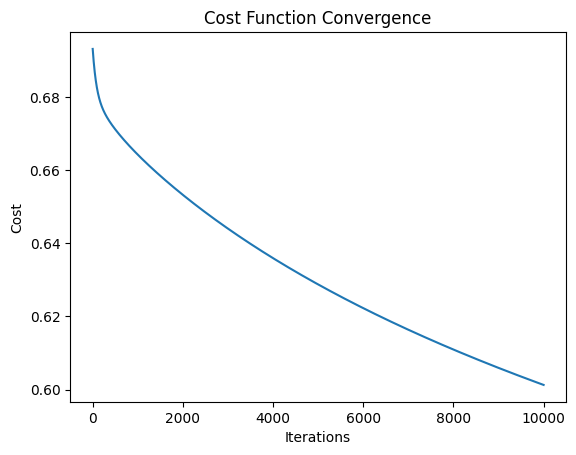

In [ ]:
# Train the logistic regression model
alpha = 0.01
num_iters = 10000
theta, J_history = gradientDescent(X_train, y_train, theta, alpha, num_iters)

# Plot the cost function over iterations
plt.plot(J_history)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Cost Function Convergence')
plt.show()

In [ ]:
# Predict sentiment for the test set
y_pred = sigmoid(np.dot(X_test, theta))
y_pred_labels = np.zeros(y_pred.shape)
for i in range(len(y_pred)):
    if y_pred[i] >= 0.5:
        y_pred_labels[i] = 1
    else:
        y_pred_labels[i] = 0
y_pred_prob = sigmoid(np.dot(X_test, theta))  # Get probabilities
y_pred_labels = (y_pred_prob >= 0.5).astype(int)  # Convert probabilities to binary labels

In [ ]:
y_pred_labels = (y_pred > 0.5).astype(int)  # Adjust the threshold if necessary

# Convert y_test to binary labels (1 for positive, 0 for negative)
y_test_binary = np.where(y_test == 0.5, 1, y_test).astype(int).flatten()

# Ensure both y_test and y_pred_labels are of the same shape and type
print("Shape of y_test:", y_test.shape)
print("Shape of y_pred_labels:", y_pred_labels.shape)

Shape of y_test: (2000, 1)
Shape of y_pred_labels: (2000, 1)


In [ ]:
# Evaluate the model
accuracy = accuracy_score(y_test_binary, y_pred_labels.flatten())
confusion = confusion_matrix(y_test_binary, y_pred_labels.flatten())

print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{confusion}")

Accuracy: 0.8235
Confusion Matrix:
[[ 137  231]
 [ 122 1510]]


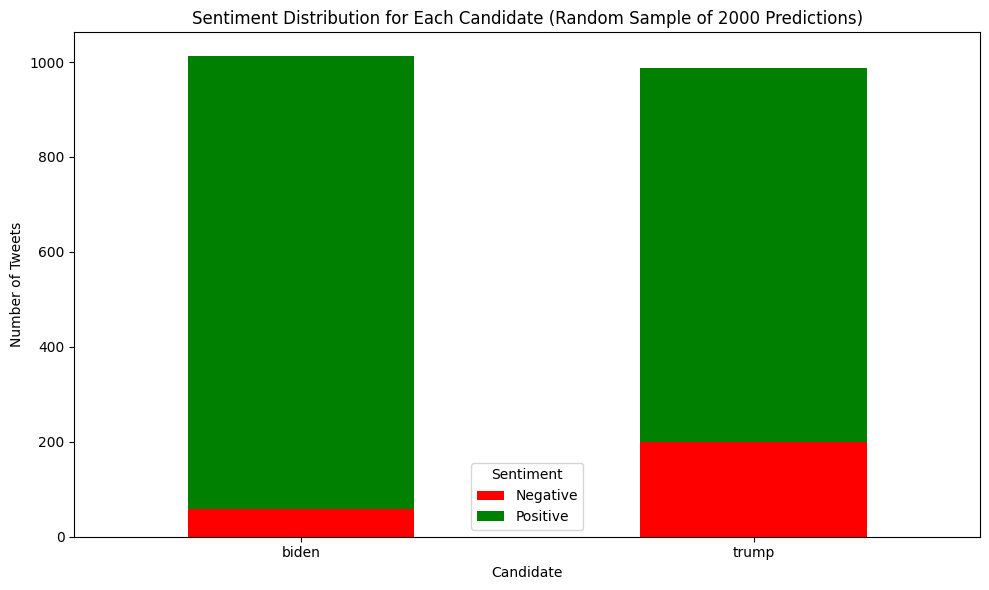

In [ ]:
# Create a DataFrame for the predictions using the original DataFrame indices
predictions_df = pd.DataFrame({
    'candidate': df.loc[test_indices, 'candidate'],  # Get candidate labels for the test set
    'predicted_label': y_pred_labels.flatten()  # Flatten to ensure correct shape
})

# Randomly sample 2000 predictions
sampled_predictions = predictions_df.sample(n=0,2*n, random_state=42)

# Count the occurrences of each sentiment for each candidate
sentiment_counts = sampled_predictions.groupby(['candidate', 'predicted_label']).size().unstack(fill_value=0)

# Define colors for each sentiment (assuming 0 = negative, 1 = positive)
colors = ['red', 'green']  # Adjust colors based on your sentiment labels

# Plotting the bar chart
sentiment_counts.plot(kind='bar', stacked=True, color=colors, figsize=(10, 6))

# Adding labels and title
plt.title('Sentiment Distribution for Each Candidate (Random Sample of 2000 Predictions)')
plt.xlabel('Candidate')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=0)  # Rotate x-axis labels for better readability
plt.legend(title='Sentiment', labels=['Negative', 'Positive'])  # Adjust labels as necessary
plt.tight_layout()  # Adjust layout to make room for the legend
plt.show()

# Nominized Graph

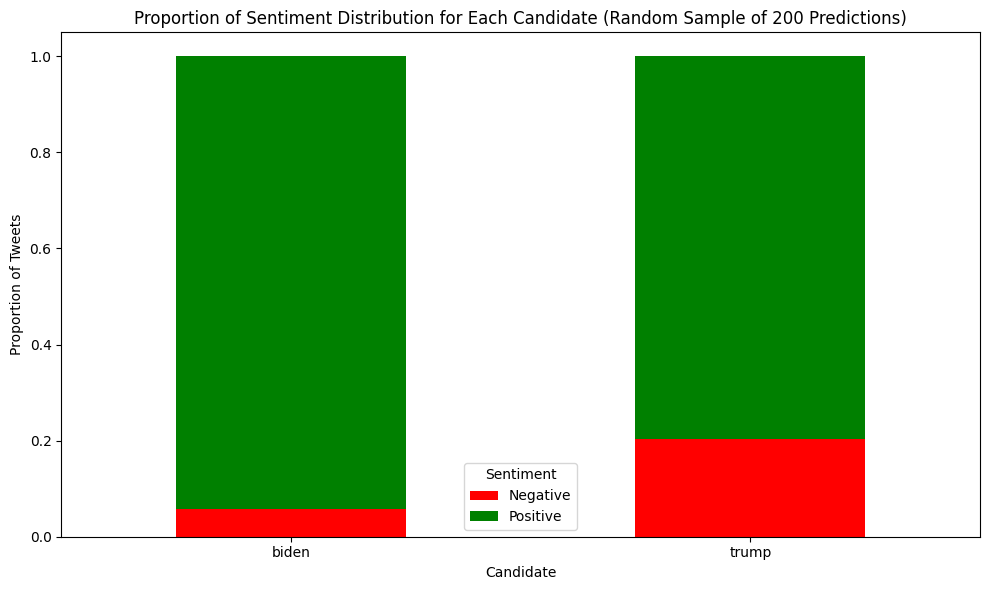

In [ ]:
# Count the occurrences of each sentiment for each candidate
sentiment_counts = sampled_predictions.groupby(['candidate', 'predicted_label']).size().unstack(fill_value=0)

# Calculate proportions
sentiment_proportions = sentiment_counts.div(sentiment_counts.sum(axis=1), axis=0)

# Define colors for each sentiment (assuming 0 = negative, 1 = positive)
colors = ['red', 'green']  # Adjust colors based on your sentiment labels

# Plotting the nominalized bar chart
sentiment_proportions.plot(kind='bar', stacked=True, color=colors, figsize=(10, 6))

# Adding labels and title
plt.title('Proportion of Sentiment Distribution for Each Candidate (Random Sample of 2000 Predictions)')
plt.xlabel('Candidate')
plt.ylabel('Proportion of Tweets')
plt.xticks(rotation=0)  # Rotate x-axis labels for better readability
plt.legend(title='Sentiment', labels=['Negative', 'Positive'])  # Adjust labels as necessary
plt.tight_layout()  # Adjust layout to make room for the legend
plt.show()

In [ ]:
# Step 1: Count potential votes (positive sentiments) for each candidate
vote_counts = predictions_df.groupby('candidate')['predicted_label'].sum()

# Step 2: Count total predictions for each candidate
total_counts = predictions_df.groupby('candidate')['predicted_label'].count()

# Step 3: Calculate the percentage of potential votes
vote_percentages = (vote_counts / total_counts) * 100

# Step 4: Create a DataFrame to display the results
vote_summary = pd.DataFrame({
    'Potential Votes': vote_counts,
    'Total Predictions': total_counts,
    'Vote Percentage': vote_percentages
}).fillna(0)  # Fill NaN values with 0 if there are candidates with no predictions

# Display the summary
print(vote_summary)

NameError: name 'predictions_df' is not defined

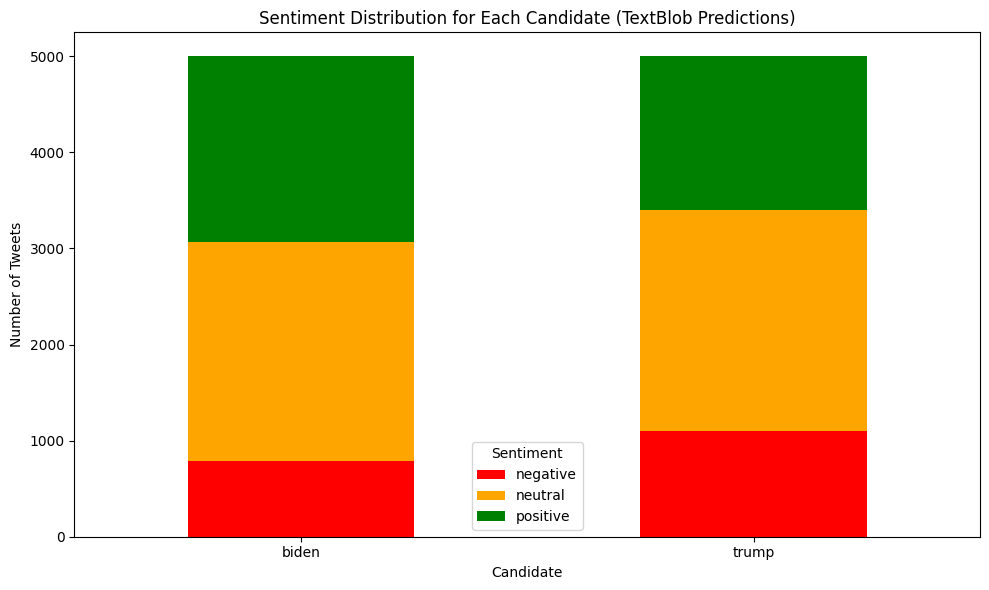

In [ ]:
# Apply the function to classify sentiments
# df['sentiment'] = df['polarity'].apply(get_polarity)

# Count the occurrences of each sentiment for each candidate
sentiment_counts = df.groupby(['candidate', 'sentiment']).size().unstack(fill_value=0)

# Plotting the sentiment counts
sentiment_counts.plot(kind='bar', stacked=True, color=['red', 'orange', 'green'], figsize=(10, 6))

# Adding labels and title
plt.title('Sentiment Distribution for Each Candidate (TextBlob Predictions)')
plt.xlabel('Candidate')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=0)  # Rotate x-axis labels for better readability
plt.legend(title='Sentiment')  # Adjust labels as necessary
plt.tight_layout()  # Adjust layout to make room for the legend
plt.show()

# Nominized Graph

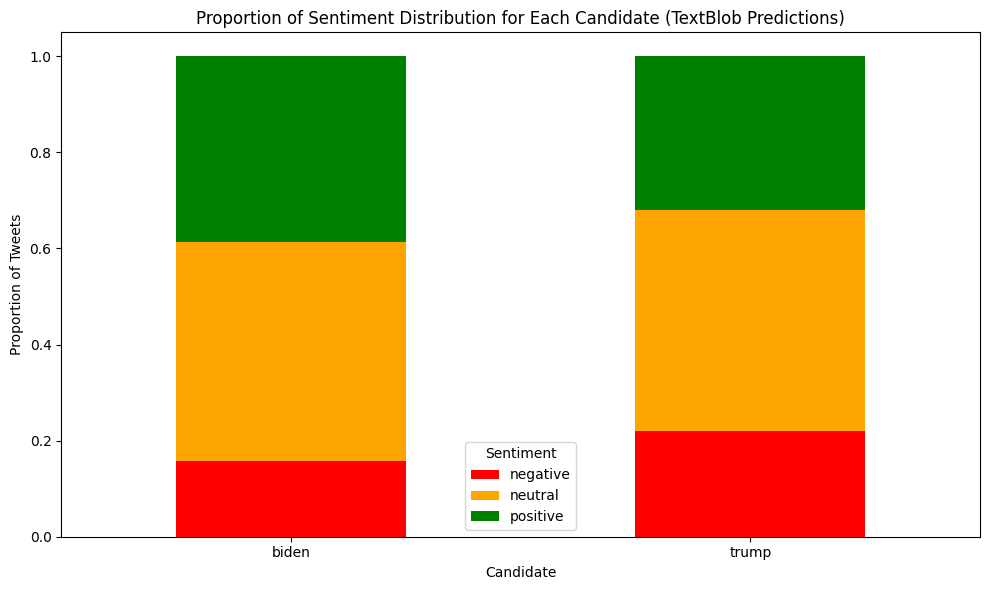

In [ ]:
# Count the occurrences of each sentiment for each candidate
sentiment_counts = df.groupby(['candidate', 'sentiment']).size().unstack(fill_value=0)

# Calculate proportions
sentiment_proportions = sentiment_counts.div(sentiment_counts.sum(axis=1), axis=0)

# Plotting the sentiment proportions
sentiment_proportions.plot(kind='bar', stacked=True, color=['red', 'orange', 'green'], figsize=(10, 6))

# Adding labels and title
plt.title('Proportion of Sentiment Distribution for Each Candidate (TextBlob Predictions)')
plt.xlabel('Candidate')
plt.ylabel('Proportion of Tweets')
plt.xticks(rotation=0)  # Rotate x-axis labels for better readability
plt.legend(title='Sentiment')  # Adjust labels as necessary
plt.tight_layout()  # Adjust layout to make room for the legend
plt.show()